In [34]:
import time
import copy
from collections import defaultdict

from pylab import rcParams

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import sampler,DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 12

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [5]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [6]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
size_test = 10000

In [8]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

In [9]:
NUM_TRAIN = 49000
NUM_VAL = 1000

loader_train = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_TRAIN, 0))

loader_val = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

In [10]:
dataloaders = {'train':loader_train,'val':loader_val}
dataset_sizes = {'train':NUM_TRAIN,'val':NUM_VAL}

In [11]:
loader_test = DataLoader(testset, batch_size=16, shuffle=True,num_workers=4)

In [12]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ##########################################################################################
    #   Il faut transposée les images car PyTorch lis les image en [Chanels, Width, Height]  #
    #   et pour les voir il faut qu'elles soient [Width, Height, Chanels]                    #
    ##########################################################################################
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

In [13]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

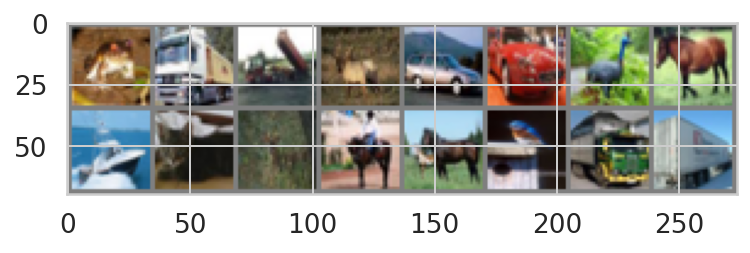

 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck


In [14]:
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [15]:
res_mod = models.resnet34(pretrained=True)

In [16]:
print(res_mod)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, len(classes))

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_mod = res_mod.to(device)

In [40]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(res_mod.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 33


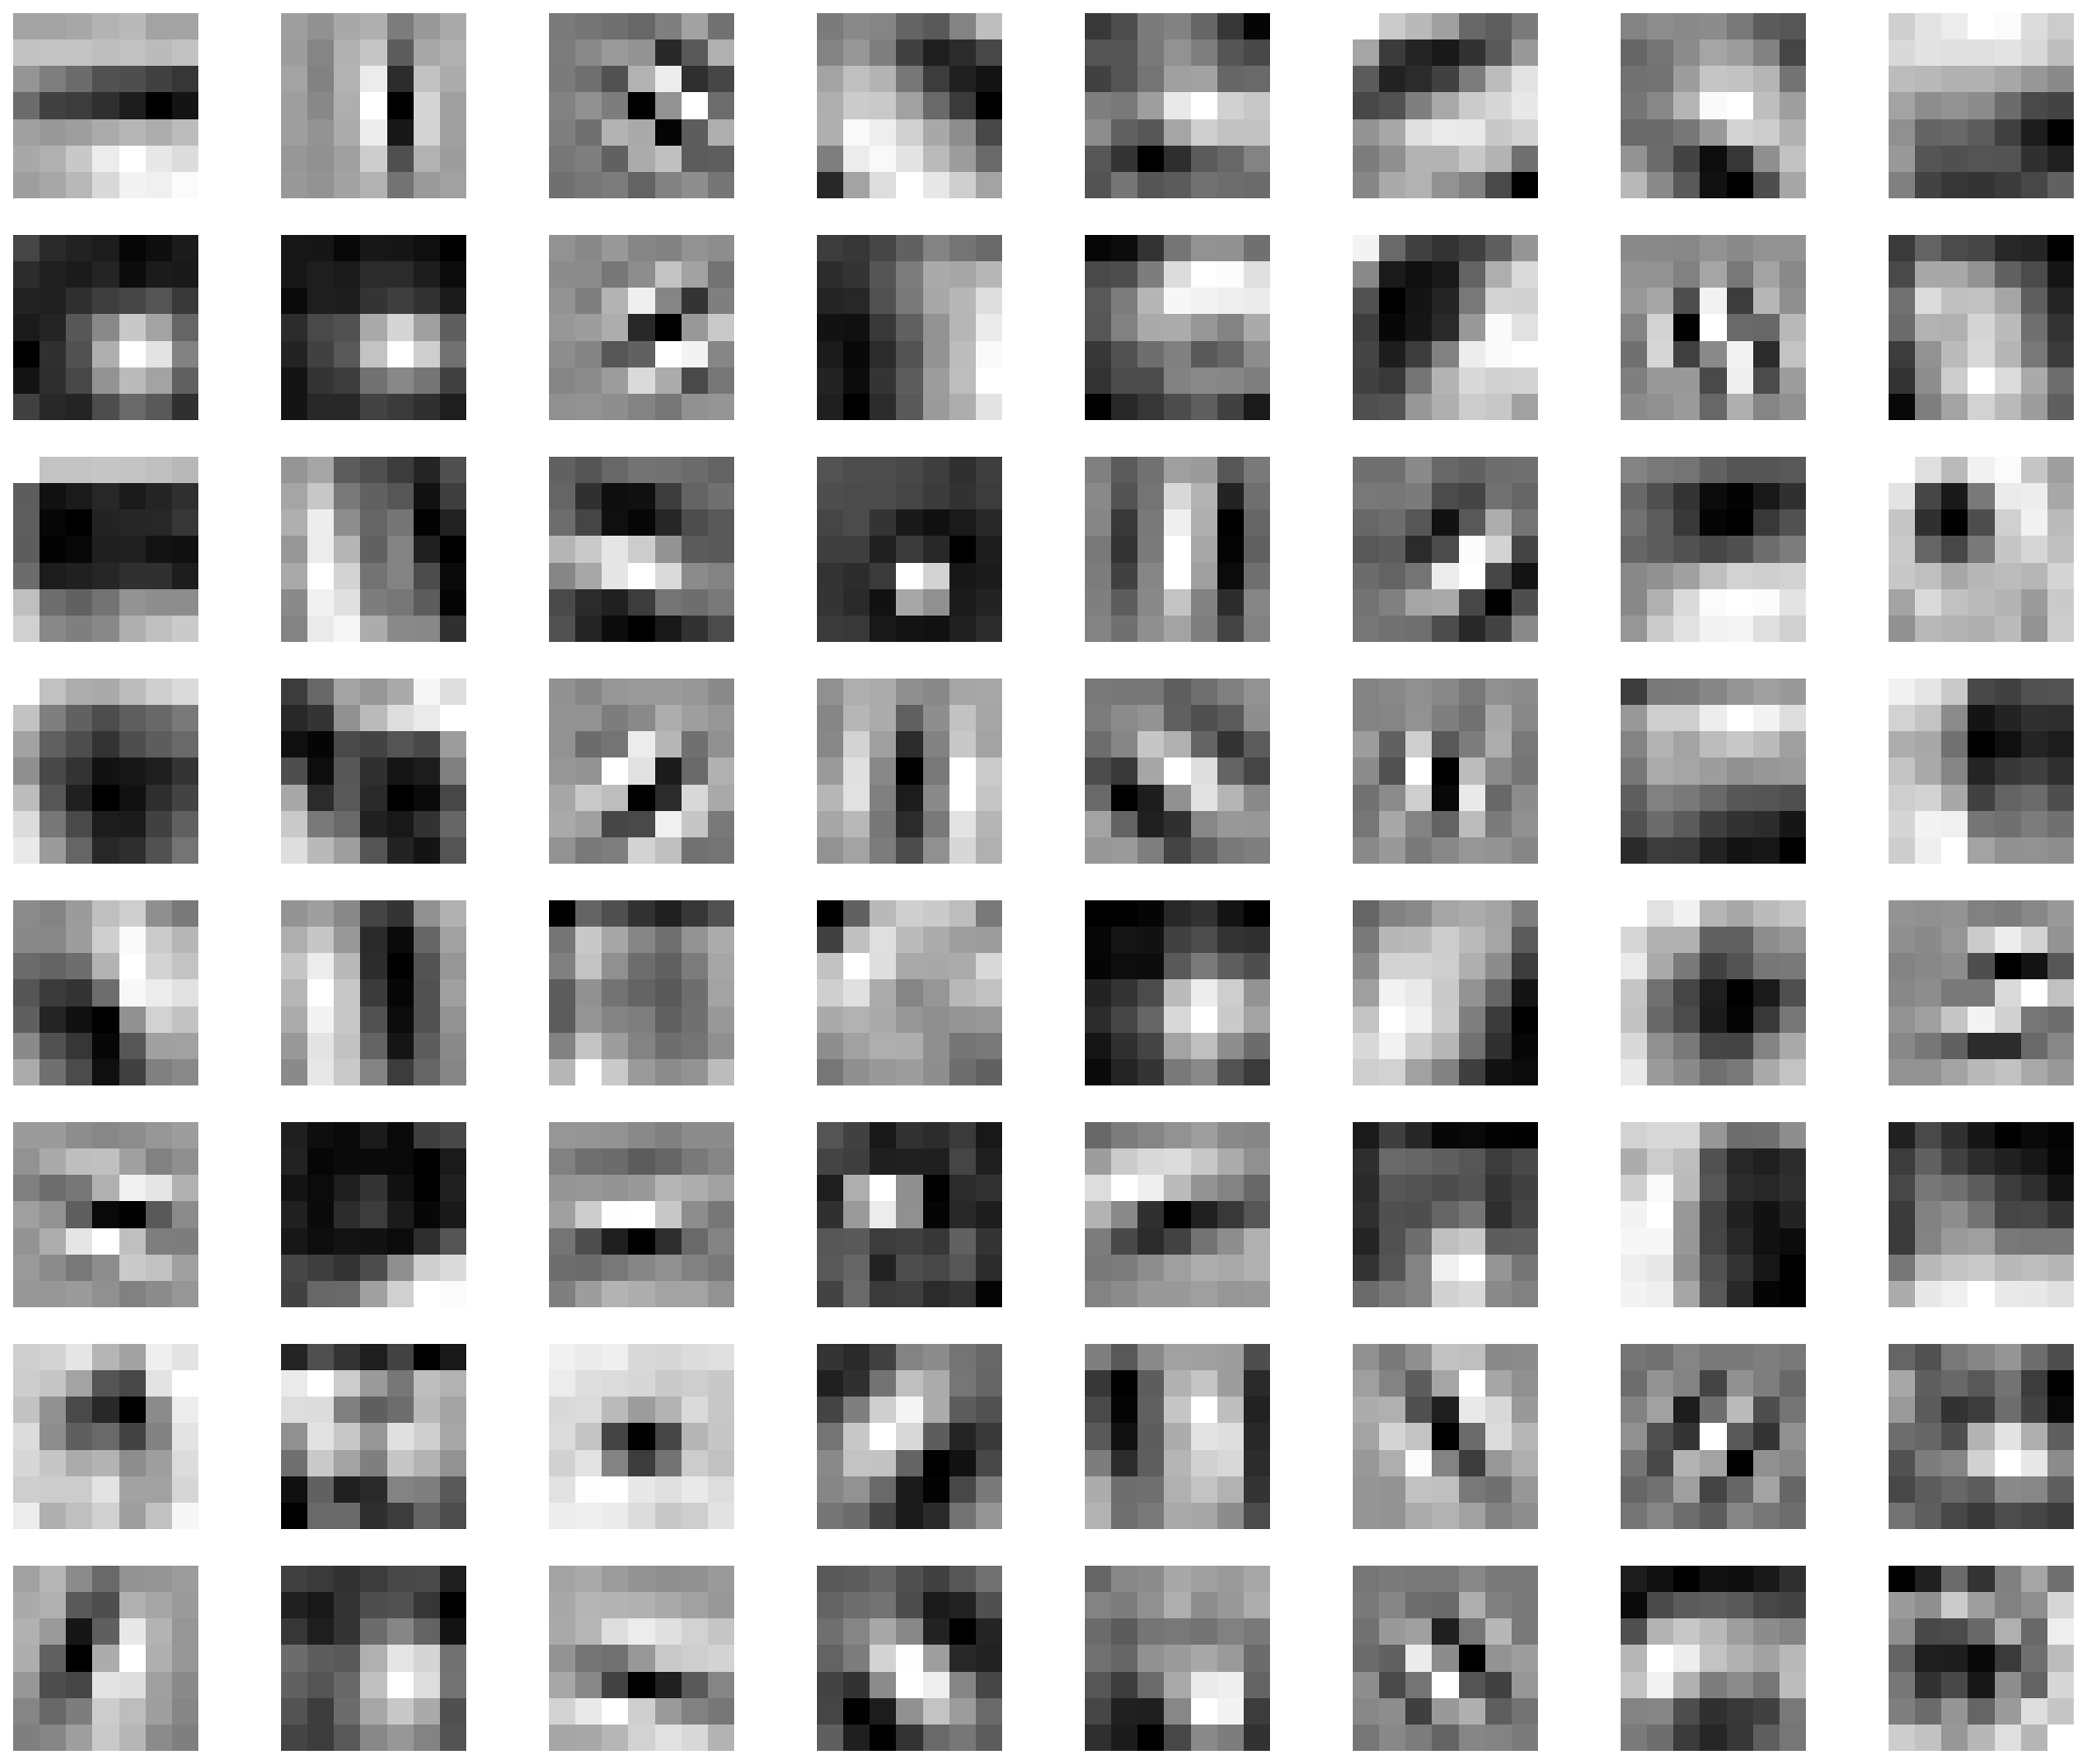

In [43]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    filter = filter.cpu()
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

In [19]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = defaultdict(list)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train' :
                train_acc = epoch_acc
                train_loss = epoch_loss 
            else :
                val_acc = epoch_acc 
                val_loss = epoch_loss 

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model_state.bin')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    model = model.to(device)
    return model,history

In [21]:
base_model,history = train_model(res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
Iterating through data...
train Loss: 1.0965 Acc: 0.6261
Iterating through data...
val Loss: 0.9968 Acc: 0.7290

Epoch 1/2
----------
Iterating through data...
train Loss: 0.8302 Acc: 0.7176
Iterating through data...
val Loss: 0.8488 Acc: 0.7280

Epoch 2/2
----------
Iterating through data...
train Loss: 0.7212 Acc: 0.7520
Iterating through data...
val Loss: 0.8529 Acc: 0.7790

Training complete in 5m 6s
Best val Acc: 0.779000


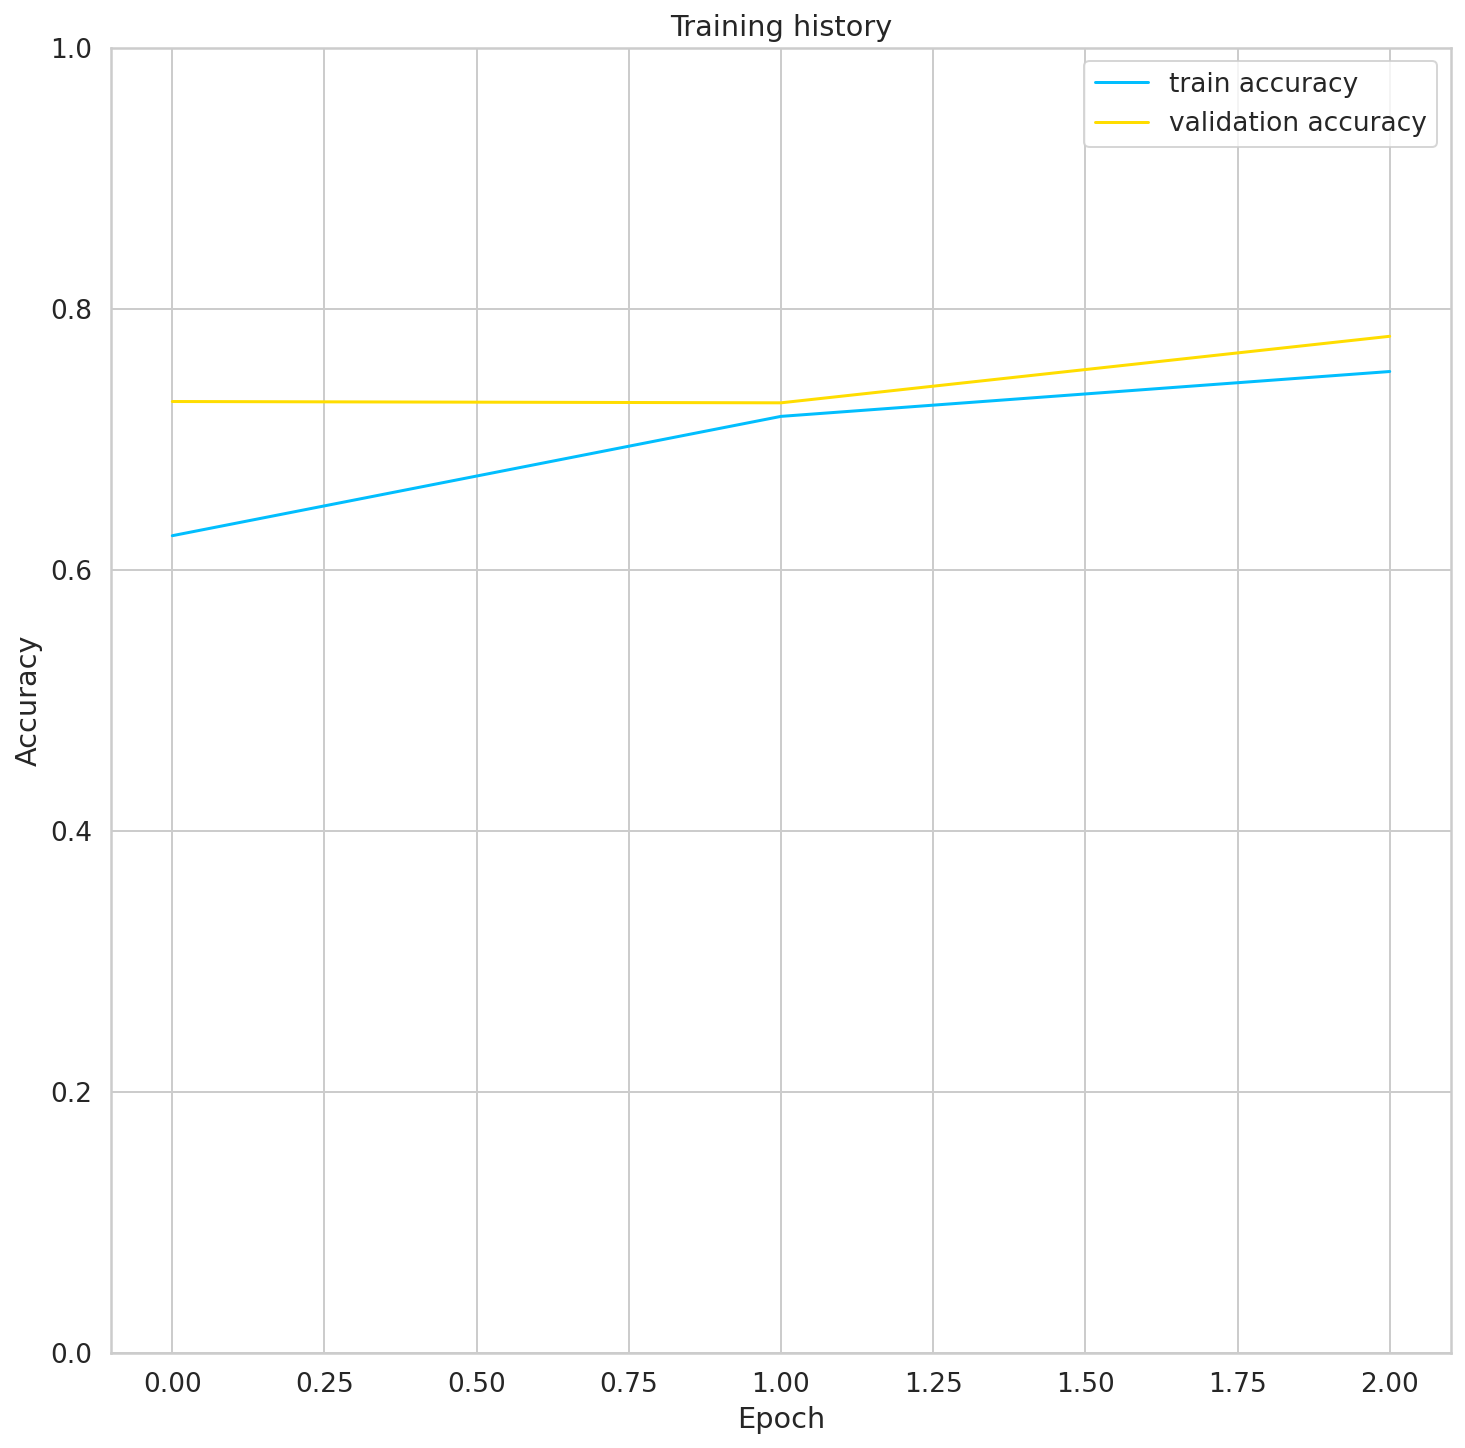

In [35]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

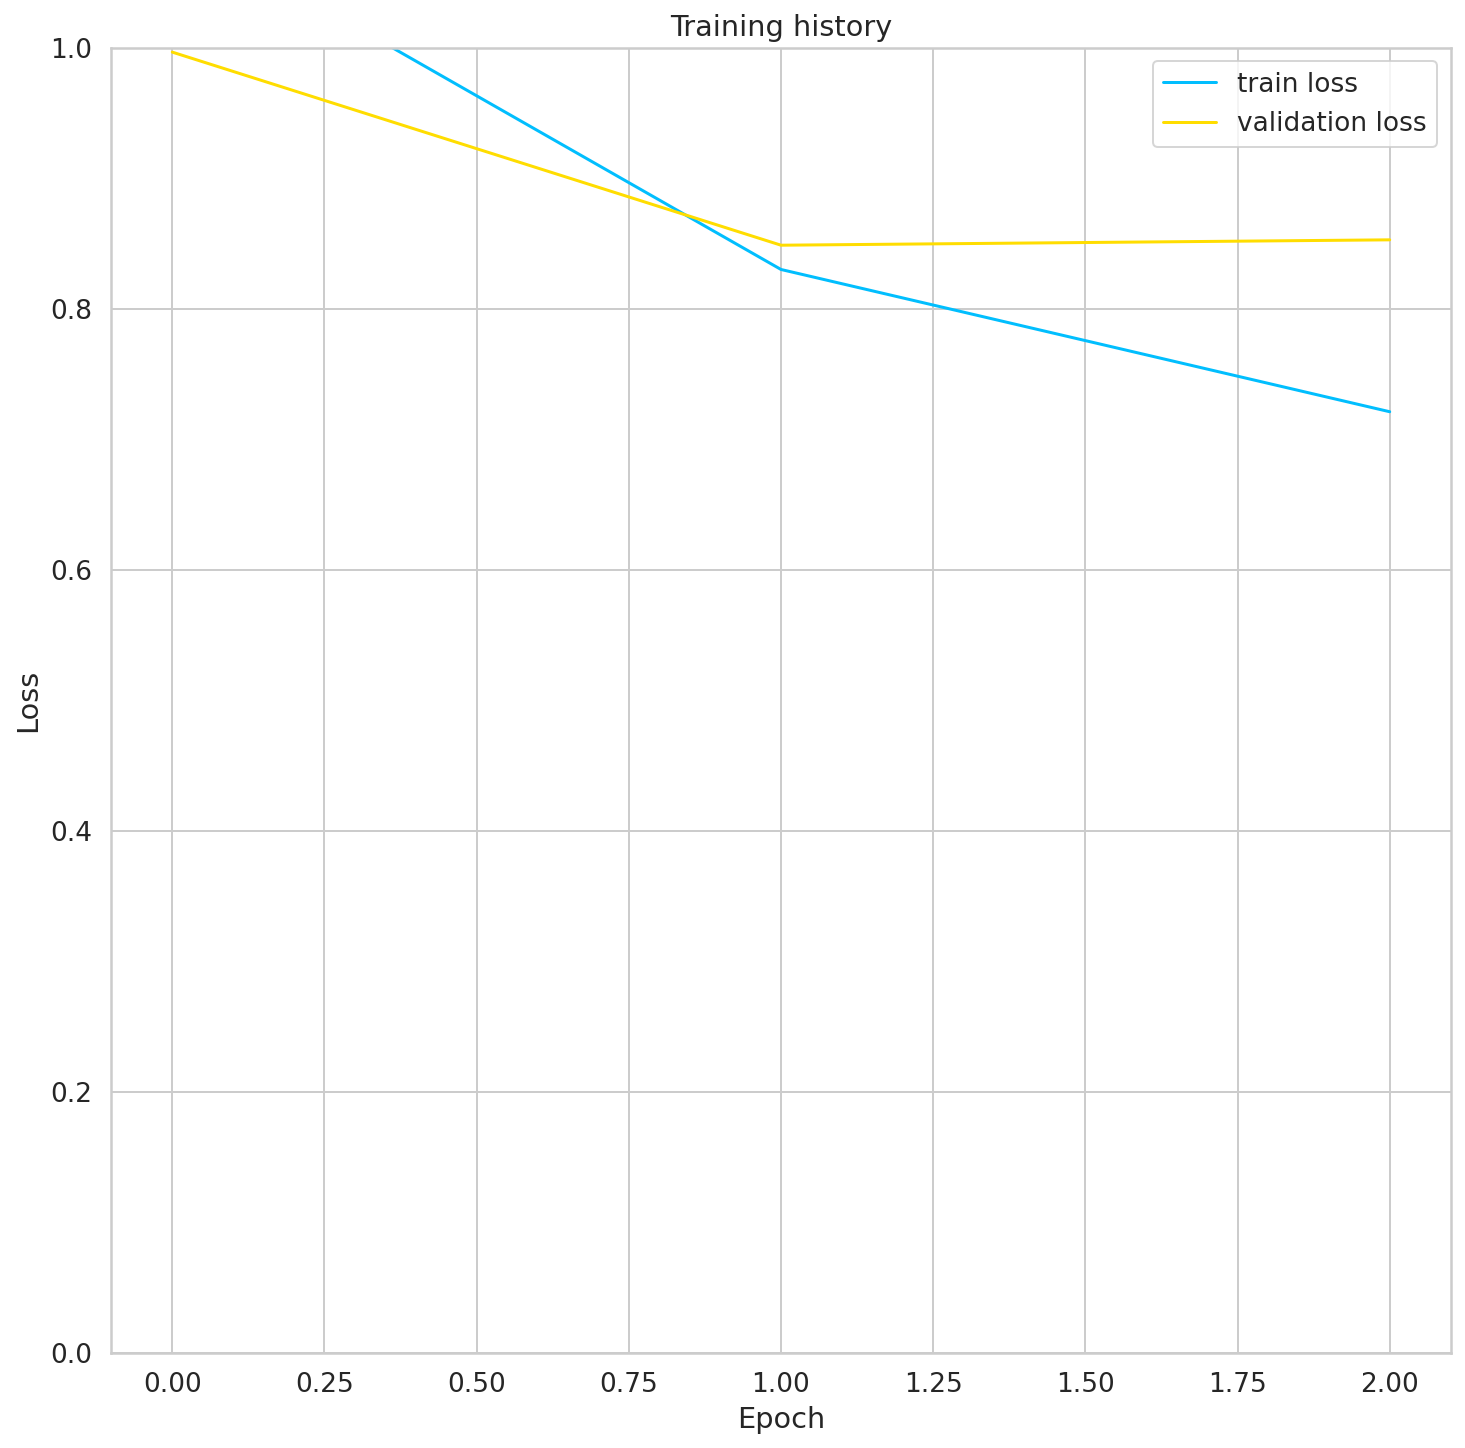

In [36]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [24]:
def eval_model(model, data_loader, loss_fn):
    model = model.eval()

    losses = []
    correct_predictions = 0
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    with torch.no_grad():
        for d in data_loader:

            # Preparing inputs
            images, targets = d
            targets = targets.to(device)
            images = images.to(device)
            

            # Running inference using the model

            outputs = model(images)
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs.data, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, targets)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == targets)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 

            losses.append(loss.item())

    return correct_predictions.double() / 10000, np.mean(losses)

In [25]:
test_acc, _ = eval_model(base_model,loader_test,criterion)

#test_acc.item()
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.76 %


In [26]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      
      # Preparing inputs
      images, targets = d
      targets = targets.to(device)
      images = images.to(device)

      outputs = model(images)
      _, preds = torch.max(outputs.data, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return  predictions, real_values

In [27]:
y_pred, y_test = get_predictions(
  base_model,
  loader_test
)

In [28]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

       plane       0.72      0.81      0.76      1000
         car       0.84      0.83      0.84      1000
        bird       0.76      0.67      0.71      1000
         cat       0.54      0.64      0.58      1000
        deer       0.71      0.78      0.75      1000
         dog       0.65      0.72      0.68      1000
        frog       0.87      0.71      0.78      1000
       horse       0.83      0.79      0.81      1000
        ship       0.89      0.83      0.86      1000
       truck       0.89      0.81      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



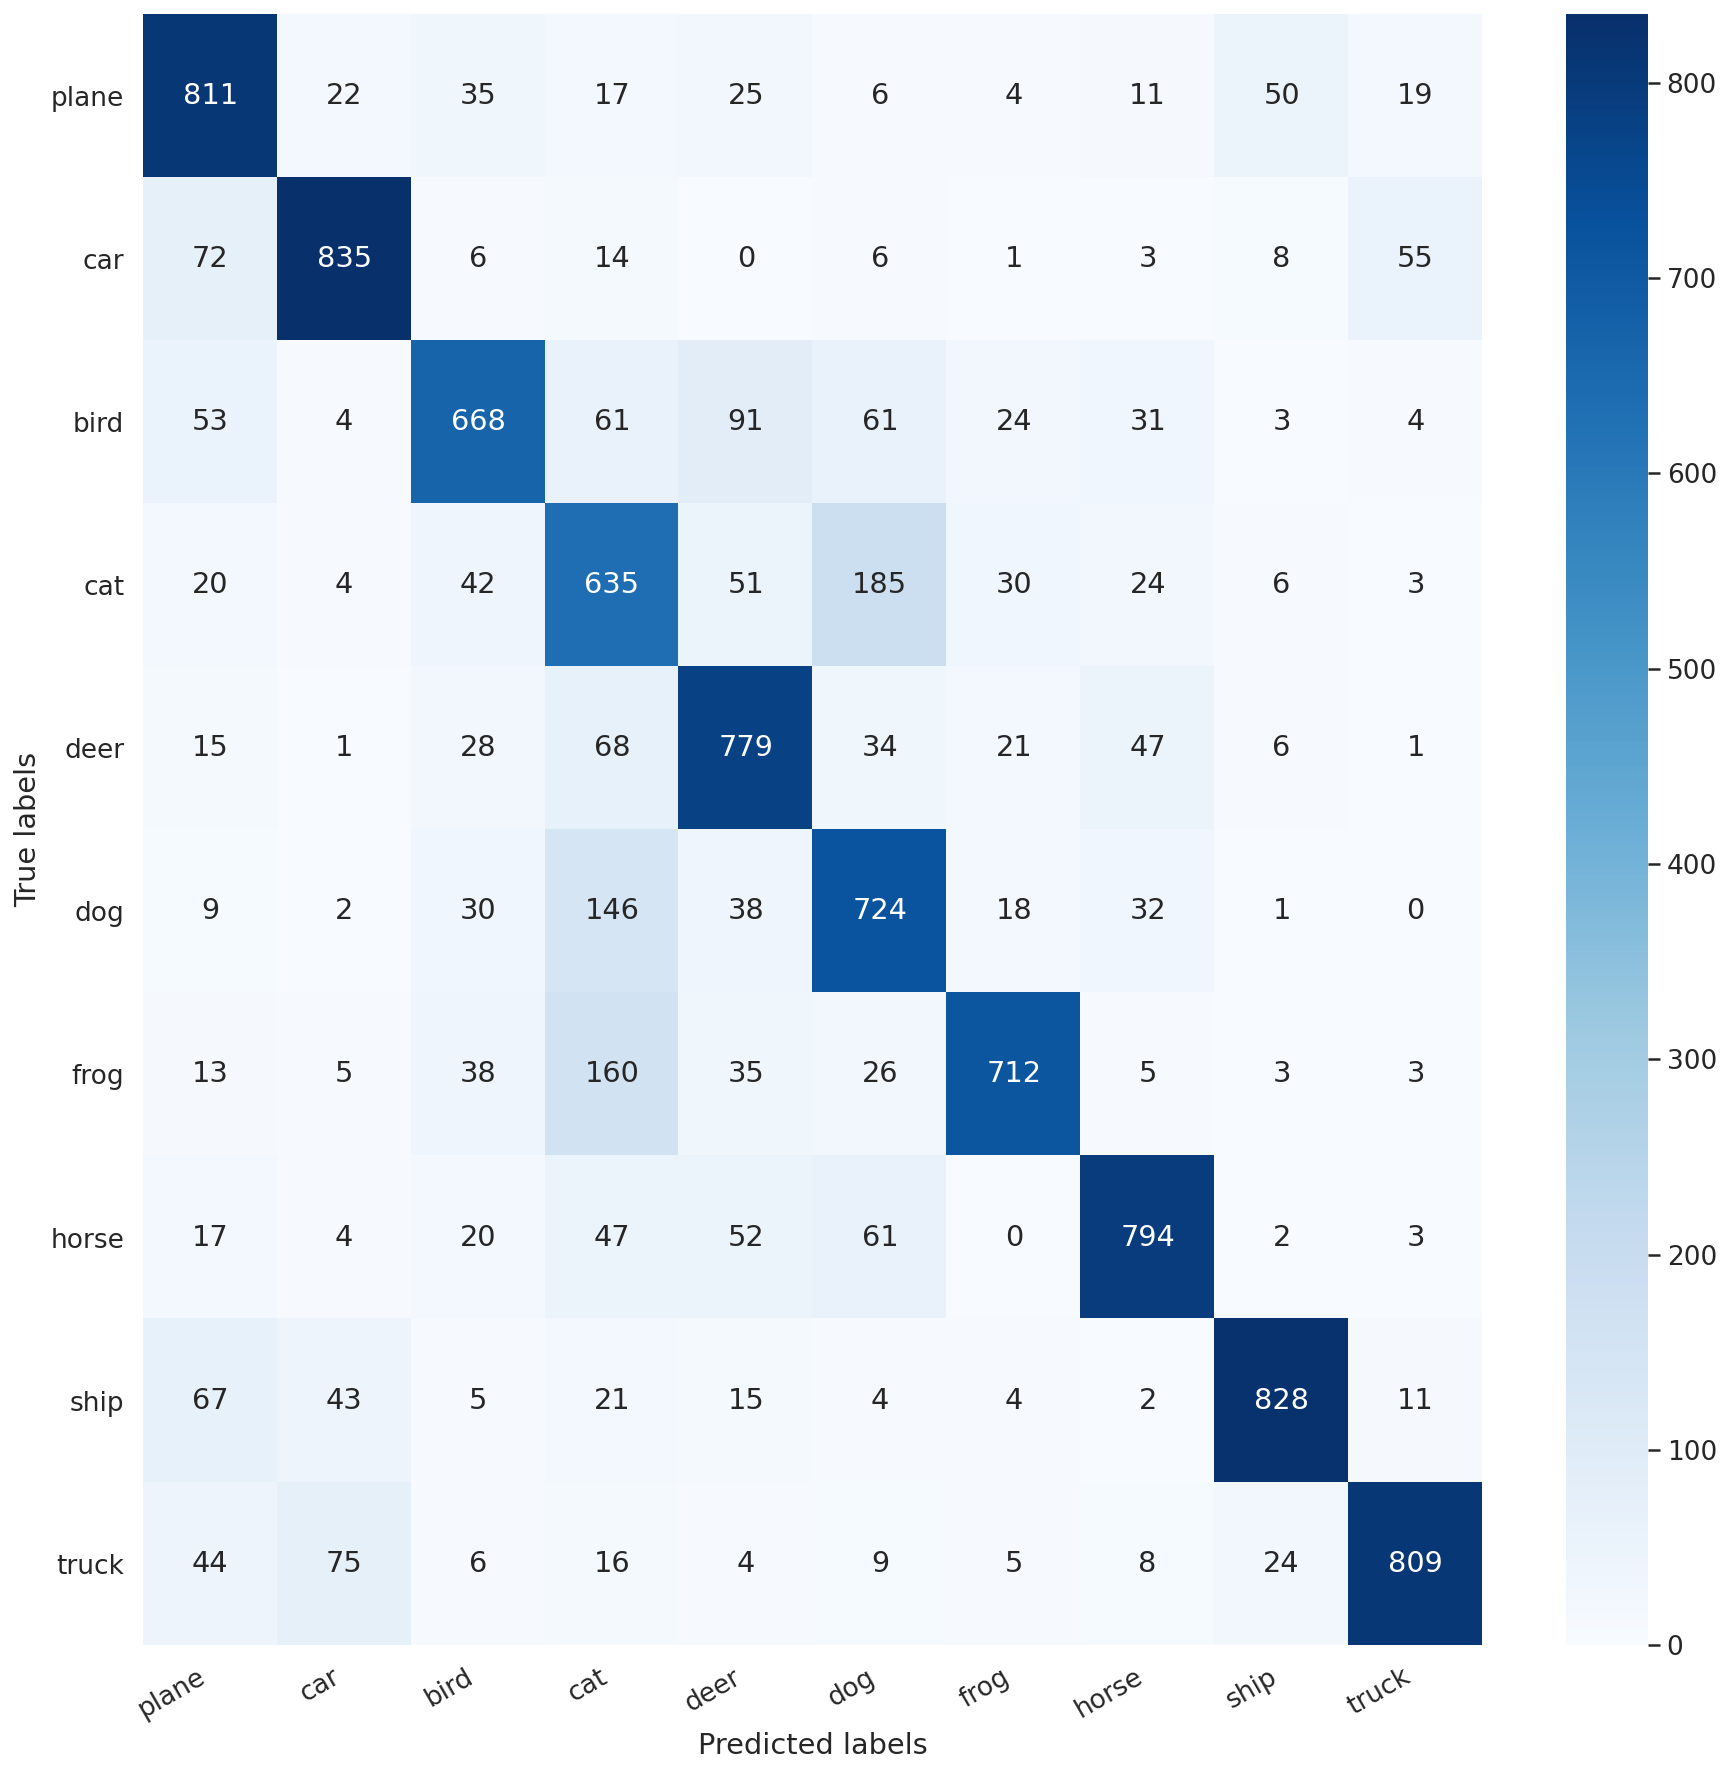

In [31]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True labels')
  plt.xlabel('Predicted labels');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
show_confusion_matrix(df_cm)

## Fine tune just a few layers

In [64]:
frozen_res_mod = models.resnet34(pretrained=True)
for param in frozen_res_mod.parameters():
    param.requires_grad = False

num_ftrs = frozen_res_mod.fc.in_features
frozen_res_mod.fc = nn.Linear(num_ftrs, len(classes))
frozen_res_mod = frozen_res_mod.to(device)
# Number of epochs for training

In [65]:
for name, child in frozen_res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [66]:
for name, child in frozen_res_mod.named_children():
    if name in ['layer4','fc']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

layer4has been unfrozen.
fchas been unfrozen.


In [67]:
EPOCHS = 10

# Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda x: x.requires_grad, frozen_res_mod.parameters()), lr=0.001, momentum=0.9)
total_steps = len(loader_train) * EPOCHS
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
base_model = train_model(frozen_res_mod, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
Iterating through data...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.3953 Acc: 0.5104
Iterating through data...
val Loss: 1.1507 Acc: 0.6440

Epoch 1/2
----------
Iterating through data...
